# Importing Libraries

In [1]:
# import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from mpl_toolkits.mplot3d import Axes3D
# import warnings

# Loading

In [2]:
# Loading 
# Loading
df = pd.read_csv('TXN_DATA_CASA.txt')
df.head(5)

,TXN_DATE,AMOUNT,TXN_INITIATOR_BRANCH,ACC_HOST_BRANCH,SOURCE_ACC,INITIATOR,TRDID,CREATE_TIME,VERIFICATION_TIME,VALUE_DATE
0,1/2/2022,12000.0,3,3,178698,SYSTEM,120006,1/2/2022 3:05:03 PM,1/2/2022 3:05:03 PM,NaN
1,1/2/2022,115.0,63,63,99949,SYSTEM,220021,1/2/2022 3:05:04 PM,1/2/2022 3:05:04 PM,NaN
2,1/2/2022,2000.0,11,11,86624,nahida011,210003,1/2/2022 3:06:05 PM,1/2/2022 3:06:05 PM,NaN
3,1/2/2022,3000.0,2,2,317458,406879,220021,1/2/2022 3:06:07 PM,1/2/2022 3:06:07 PM,1/2/2022 2:54:43 PM
4,1/2/2022,30000.0,55,55,161491,SHA779,220021,1/2/2022 12:53:07 PM,1/2/2022 12:53:07 PM,NaN


# Exploratory Data Analysis and Preprocessing

In [3]:
print(f"info of the data \n{df.info()}\n\n")
print(f"\n numerical description \n{df.describe()}\n\n")
print(f"\ncheking null values \n\n{df.isnull().sum()}\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954049 entries, 0 to 1954048
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   TXN_DATE              object 
 1   AMOUNT                float64
 2   TXN_INITIATOR_BRANCH  int64  
 3   ACC_HOST_BRANCH       int64  
 4   SOURCE_ACC            int64  
 5   INITIATOR             object 
 6   TRDID                 int64  
 7   CREATE_TIME           object 
 8   VERIFICATION_TIME     object 
 9   VALUE_DATE            object 
dtypes: float64(1), int64(4), object(5)
memory usage: 149.1+ MB
info of the data 
None



 numerical description 
             AMOUNT  TXN_INITIATOR_BRANCH  ACC_HOST_BRANCH    SOURCE_ACC  \
count  1.954049e+06          1.954049e+06     1.954049e+06  1.954049e+06   
mean   2.667268e+05          1.337470e+02     4.315533e+01  1.920262e+05   
std    9.029367e+06          2.816360e+02     2.742390e+01  9.913730e+04   
min    1.000000e-02          1.000000e+00     2.0

In [4]:
# new col with 0 and 1 for Value_date column
df['VALUE_DATE_FLAG'] = df['VALUE_DATE'].notnull().astype(int)
df.drop(columns=["VALUE_DATE"],inplace=True)
df.head(5)


,TXN_DATE,AMOUNT,TXN_INITIATOR_BRANCH,ACC_HOST_BRANCH,SOURCE_ACC,INITIATOR,TRDID,CREATE_TIME,VERIFICATION_TIME,VALUE_DATE_FLAG
0,1/2/2022,12000.0,3,3,178698,SYSTEM,120006,1/2/2022 3:05:03 PM,1/2/2022 3:05:03 PM,0
1,1/2/2022,115.0,63,63,99949,SYSTEM,220021,1/2/2022 3:05:04 PM,1/2/2022 3:05:04 PM,0
2,1/2/2022,2000.0,11,11,86624,nahida011,210003,1/2/2022 3:06:05 PM,1/2/2022 3:06:05 PM,0
3,1/2/2022,3000.0,2,2,317458,406879,220021,1/2/2022 3:06:07 PM,1/2/2022 3:06:07 PM,1
4,1/2/2022,30000.0,55,55,161491,SHA779,220021,1/2/2022 12:53:07 PM,1/2/2022 12:53:07 PM,0


In [5]:
# Extracting categorical and numerical columns
cat_cols=df.select_dtypes(include=["object"]).columns
print(cat_cols)
num_cols=df.select_dtypes(include=["int","float"]).columns
print(f"numerical column {num_cols}")

Index(['TXN_DATE', 'INITIATOR', 'CREATE_TIME', 'VERIFICATION_TIME'], dtype='object')
numerical column Index(['AMOUNT', 'TXN_INITIATOR_BRANCH', 'ACC_HOST_BRANCH', 'SOURCE_ACC',
       'TRDID', 'VALUE_DATE_FLAG'],
      dtype='object')


In [6]:
# Checking unique values across the numerical column
print(len(df["TXN_INITIATOR_BRANCH"].unique()),df["TXN_INITIATOR_BRANCH"].unique())
print(len(df["ACC_HOST_BRANCH"].unique()),df["ACC_HOST_BRANCH"].unique())
print(len(df["SOURCE_ACC"].unique()),df["SOURCE_ACC"].unique())
print(len(df["TRDID"].unique()),df["TRDID"].unique())

106 [  3  63  11   2  55 102  35  57 105  62  49  33  53  46  76  94  96  92
  70  82  28  91  23  40  48  42  39  67  41   6   5   8  20  15  26  83
  29  43  37  81  78  25  98  27 100  10  21  79  12  99  75  50  88  66
  64  97  85  90   9  68  60  84  44  61  34  24  73  71  22  65  93  52
  32  87  54  72  45  95  38  36 999   7  14  77  74  30  56  19 104  16
  17  31  59  89  51  13 103  86  47  18   1  69  58   4  80 101]
104 [  3  63  11   2  55 102  35  57 105  62  49  33  53  67  76  46  94  96
  92  70   8  25  28  91  23  40  48  42  39  71  41   6   5  37  20  15
  26  83  29  43  81  78 100  98  27  10  60  21  79  12  99  75  50  88
  66  64  97  82  85  90   9  38  68  84  44  58  61  34  22  24  18  73
  65  93  54  36  32  87  72  45  95   4   7  14  56  77  74  69  30  52
  19  59 104  16  17  31  13  47  89  80 101  51 103  86]
142710 [178698  99949  86624 ... 355491 355501 355490]
12 [120006 220021 210003 230004 220089 110003 120089 120001 230002 220001
 130002 2

### Processing of Numerical Column

In [7]:
# Applying frequency encoding to 'TXN_INITIATOR_BRANCH', 'ACC_HOST_BRANCH', 'SOURCE_ACC'

# for 'TXN_INITIATOR_BRANCH'
initiator_freq = df['TXN_INITIATOR_BRANCH'].value_counts(normalize=True)
# Map 
initiator_freq_mapping = initiator_freq.to_dict()
# Replace 
df['TXN_INITIATOR_BRANCH_FREQ'] = df['TXN_INITIATOR_BRANCH'].map(initiator_freq_mapping)

# for 'ACC_HOST_BRANCH'
acc_host_freq = df['ACC_HOST_BRANCH'].value_counts(normalize=True)
acc_host_freq_mapping = acc_host_freq.to_dict()
df['ACC_HOST_BRANCH_FREQ'] = df['ACC_HOST_BRANCH'].map(acc_host_freq_mapping)

# for SOURCE_ACC
source_acc_freq = df['SOURCE_ACC'].value_counts(normalize=True)
source_acc_freq_mapping = source_acc_freq.to_dict()
df['SOURCE_ACC_FREQ'] = df['SOURCE_ACC'].map(source_acc_freq_mapping)

# Drop original 
df.drop(columns=['TXN_INITIATOR_BRANCH', 'ACC_HOST_BRANCH','SOURCE_ACC'], inplace=True)

In [8]:
# one-hot encoding to TRDID
df= pd.get_dummies(df, columns=['TRDID'], prefix='TRDID')

# encoded columns
one_hot_cols = [col for col in df.columns if col.startswith('TRDID_')]

# Convert to integer type
df[one_hot_cols] = df[one_hot_cols].astype(float)

df.head(2)


,TXN_DATE,AMOUNT,INITIATOR,CREATE_TIME,VERIFICATION_TIME,VALUE_DATE_FLAG,TXN_INITIATOR_BRANCH_FREQ,ACC_HOST_BRANCH_FREQ,SOURCE_ACC_FREQ,TRDID_110003,...,TRDID_120006,TRDID_120089,TRDID_130002,TRDID_210003,TRDID_220001,TRDID_220002,TRDID_220021,TRDID_220089,TRDID_230002,TRDID_230004
0,1/2/2022,12000.0,SYSTEM,1/2/2022 3:05:03 PM,1/2/2022 3:05:03 PM,0,0.008563,0.01238,0.000006,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1/2/2022,115.0,SYSTEM,1/2/2022 3:05:04 PM,1/2/2022 3:05:04 PM,0,0.009114,0.01038,0.000004,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


 # preprocessing object/categorical cols

In [9]:
df['TXN_DATE'] = pd.to_datetime(df['TXN_DATE'])
df['CREATE_TIME'] = pd.to_datetime(df['CREATE_TIME'])
df['VERIFICATION_TIME'] = pd.to_datetime(df['VERIFICATION_TIME'])

C:\Users\klikh\AppData\Local\Temp\ipykernel_8616\2636213000.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CREATE_TIME'] = pd.to_datetime(df['CREATE_TIME'])
C:\Users\klikh\AppData\Local\Temp\ipykernel_8616\2636213000.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['VERIFICATION_TIME'] = pd.to_datetime(df['VERIFICATION_TIME'])


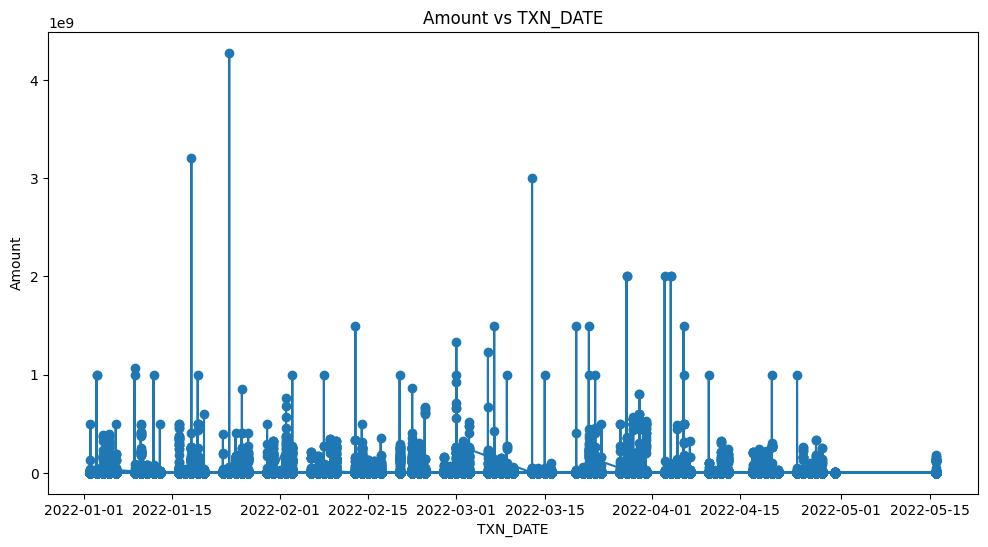

In [10]:
# Plot time series for datetime features
plt.figure(figsize=(12, 6))
plt.plot(df['TXN_DATE'], df['AMOUNT'], marker='o', linestyle='-')
plt.title('Amount vs TXN_DATE')
plt.xlabel('TXN_DATE')
plt.ylabel('Amount')
plt.show()

In [11]:
# frequency encoding for initiator
init_freq = df['INITIATOR'].value_counts(normalize=True)

# Map 
init_freq_mapping = init_freq.to_dict()

# Replace 
df['INITIATOR_FREQ'] = df['INITIATOR'].map(init_freq_mapping)
#drop original 
df.drop(columns=['INITIATOR'], inplace=True)

# Feature Engineering

In [12]:
# Extract datetime features
df['TXN_MONTH'] = df['TXN_DATE'].dt.month
df['TXN_DAY'] = df['TXN_DATE'].dt.day
df['CREATE_HOUR'] = df['CREATE_TIME'].dt.hour
df['VERIFICATION_MONTH'] = df['VERIFICATION_TIME'].dt.month
df['TXN_DAY_OF_WEEK'] = df['TXN_DATE'].dt.dayofweek
df['VERIFICATION_DAY_OF_WEEK'] = df['VERIFICATION_TIME'].dt.dayofweek
# Calculate time differences
df['CREATE_VERIFICATION_TIMEDIFF'] = (df['VERIFICATION_TIME'] - df['CREATE_TIME']).dt.seconds
# Create binary features
df['TXN_END_OF_MONTH'] = (df['TXN_DATE'].dt.is_month_end).astype(int)
df['TXN_WEEKEND'] = (df['TXN_DATE'].dt.dayofweek >= 5).astype(int)

In [13]:
df.head(4)

,TXN_DATE,AMOUNT,CREATE_TIME,VERIFICATION_TIME,VALUE_DATE_FLAG,TXN_INITIATOR_BRANCH_FREQ,ACC_HOST_BRANCH_FREQ,SOURCE_ACC_FREQ,TRDID_110003,TRDID_120001,...,INITIATOR_FREQ,TXN_MONTH,TXN_DAY,CREATE_HOUR,VERIFICATION_MONTH,TXN_DAY_OF_WEEK,VERIFICATION_DAY_OF_WEEK,CREATE_VERIFICATION_TIMEDIFF,TXN_END_OF_MONTH,TXN_WEEKEND
0,2022-01-02,12000.0,2022-01-02 15:05:03,2022-01-02 15:05:03,0,0.008563,0.012380,0.000006,0.0,0.0,...,0.234117,1,2,15,1,6,6,0,0,1
1,2022-01-02,115.0,2022-01-02 15:05:04,2022-01-02 15:05:04,0,0.009114,0.010380,0.000004,0.0,0.0,...,0.234117,1,2,15,1,6,6,0,0,1
2,2022-01-02,2000.0,2022-01-02 15:06:05,2022-01-02 15:06:05,0,0.007786,0.009096,0.000005,0.0,0.0,...,0.000701,1,2,15,1,6,6,0,0,1
3,2022-01-02,3000.0,2022-01-02 15:06:07,2022-01-02 15:06:07,1,0.028786,0.042373,0.000007,0.0,0.0,...,0.000002,1,2,15,1,6,6,0,0,1


# Scaling and Dropping

In [14]:
# Dropping 
df.drop(columns=['TXN_DATE', 'CREATE_TIME', 'VERIFICATION_TIME'], inplace=True)

In [15]:
# Scaling 
scaler = MinMaxScaler()
df[['AMOUNT','CREATE_VERIFICATION_TIMEDIFF']] = scaler.fit_transform(df[['AMOUNT','CREATE_VERIFICATION_TIMEDIFF']])

In [16]:
print(df.shape)
print(df.isnull().sum())
df.head(3)

(1954049, 27)
AMOUNT                          0
VALUE_DATE_FLAG                 0
TXN_INITIATOR_BRANCH_FREQ       0
ACC_HOST_BRANCH_FREQ            0
SOURCE_ACC_FREQ                 0
TRDID_110003                    0
TRDID_120001                    0
TRDID_120006                    0
TRDID_120089                    0
TRDID_130002                    0
TRDID_210003                    0
TRDID_220001                    0
TRDID_220002                    0
TRDID_220021                    0
TRDID_220089                    0
TRDID_230002                    0
TRDID_230004                    0
INITIATOR_FREQ                  0
TXN_MONTH                       0
TXN_DAY                         0
CREATE_HOUR                     0
VERIFICATION_MONTH              0
TXN_DAY_OF_WEEK                 0
VERIFICATION_DAY_OF_WEEK        0
CREATE_VERIFICATION_TIMEDIFF    0
TXN_END_OF_MONTH                0
TXN_WEEKEND                     0
dtype: int64


,AMOUNT,VALUE_DATE_FLAG,TXN_INITIATOR_BRANCH_FREQ,ACC_HOST_BRANCH_FREQ,SOURCE_ACC_FREQ,TRDID_110003,TRDID_120001,TRDID_120006,TRDID_120089,TRDID_130002,...,INITIATOR_FREQ,TXN_MONTH,TXN_DAY,CREATE_HOUR,VERIFICATION_MONTH,TXN_DAY_OF_WEEK,VERIFICATION_DAY_OF_WEEK,CREATE_VERIFICATION_TIMEDIFF,TXN_END_OF_MONTH,TXN_WEEKEND
0,2.803736e-06,0,0.008563,0.012380,0.000006,0.0,0.0,1.0,0.0,0.0,...,0.234117,1,2,15,1,6,6,0.0,0,1
1,2.686682e-08,0,0.009114,0.010380,0.000004,0.0,0.0,0.0,0.0,0.0,...,0.234117,1,2,15,1,6,6,0.0,0,1
2,4.672874e-07,0,0.007786,0.009096,0.000005,0.0,0.0,0.0,0.0,0.0,...,0.000701,1,2,15,1,6,6,0.0,0,1


# Fit Model

### Auto Encoder

Pipeline : High Recaller Model (Auto Encoder Model) --> False Positive Reducer ( any supervised model(ann,classifier etc.)) --> Real Time prediction

#### Part 1 : High Recaller Model ( Auto Encoder)

In [17]:
# Define the autoencoder model
autoencoder = tf.keras.models.Sequential([

    # Encoding layers
    layers.Dense(64, activation='relu', input_shape=(df.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),

    # Decoding layers
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(df.shape[1], activation='relu')
])


In [18]:
# Early stopping callback
early_stop =keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
)

checkpoint = keras.callbacks.ModelCheckpoint("best_model.h5", 
                             monitor='loss', 
                             save_best_only=True, 
                             mode='min',
                             save_weights_only=False) 

In [19]:
# Compile 
autoencoder.compile(optimizer="adam", loss="mse")
# model architecture
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1792      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 27)                1755      
                                                                 
Total params: 8811 (34.42 KB)
Trainable params: 8811 (34

In [20]:
history = autoencoder.fit(
    df, df,
    shuffle=True,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop,checkpoint],
   verbose=2
)

Epoch 1/20
30533/30533 - 33s - loss: 0.0555 - 33s/epoch - 1ms/step
Epoch 2/20


c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30533/30533 - 32s - loss: 0.0398 - 32s/epoch - 1ms/step
Epoch 3/20
30533/30533 - 32s - loss: 0.0398 - 32s/epoch - 1ms/step
Epoch 4/20
30533/30533 - 32s - loss: 0.0398 - 32s/epoch - 1ms/step
Epoch 5/20
30533/30533 - 32s - loss: 0.0398 - 32s/epoch - 1ms/step
Epoch 6/20
30533/30533 - 33s - loss: 0.0398 - 33s/epoch - 1ms/step
Epoch 7/20
30533/30533 - 35s - loss: 0.0398 - 35s/epoch - 1ms/step
Epoch 8/20
30533/30533 - 49s - loss: 0.0397 - 49s/epoch - 2ms/step
Epoch 9/20
30533/30533 - 45s - loss: 0.0397 - 45s/epoch - 1ms/step
Epoch 10/20
30533/30533 - 39s - loss: 0.0397 - 39s/epoch - 1ms/step
Epoch 11/20
30533/30533 - 34s - loss: 0.0397 - 34s/epoch - 1ms/step
Epoch 12/20
30533/30533 - 35s - loss: 0.0397 - 35s/epoch - 1ms/step
Epoch 13/20
30533/30533 - 34s - loss: 0.0397 - 34s/epoch - 1ms/step
Epoch 14/20
30533/30533 - 33s - loss: 0.0397 - 33s/epoch - 1ms/step
Epoch 15/20
30533/30533 - 34s - loss: 0.0397 - 34s/epoch - 1ms/step
Epoch 16/20
30533/30533 - 34s - loss: 0.0397 - 34s/epoch - 1ms/step

##### Ccalculating reconstruction errror

In [21]:
# reconstruction
reconstructed_data = autoencoder.predict(df)
# reconstruction error 
mse = np.mean(np.square(df - reconstructed_data), axis=1)

# threshold 
threshold = np.percentile(mse, 98)

# Identify anomalies 
anomaly_mask_ae = (mse > threshold)
# Print number of anomalies
num_anomalies_ae = np.sum(anomaly_mask_ae)
print("Number of anomalies:", num_anomalies_ae)

61065/61065 [==============================] - 64s 1ms/step
Number of anomalies: 39081


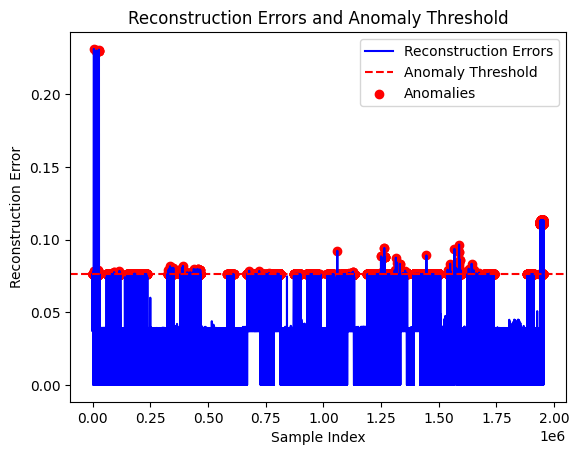

In [22]:
# Plot the reconstruction curve
plt.plot(mse, label='Reconstruction Errors', color='blue')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')

# Plot anomalies 
anomalies_indices = [i for i, error in enumerate(mse) if error > threshold]
plt.scatter(anomalies_indices, [mse[i] for i in anomalies_indices], color='red', label='Anomalies')

plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors and Anomaly Threshold')
plt.legend()
plt.show()

**Note** From the graph it is clearly visible that after .07 the errors are not normal. these are the anomalies. So we can set threshold value .07. However, here putting lower threshold ensures us about the high recall value. That means we want our model will successfully predict all the fradulant cases. There is a chance that false positive is also higher if we set threshold lower. To overcome this problem I mean to increase both high precision and high recall later I will apply a classifier model which will reduce false positive.

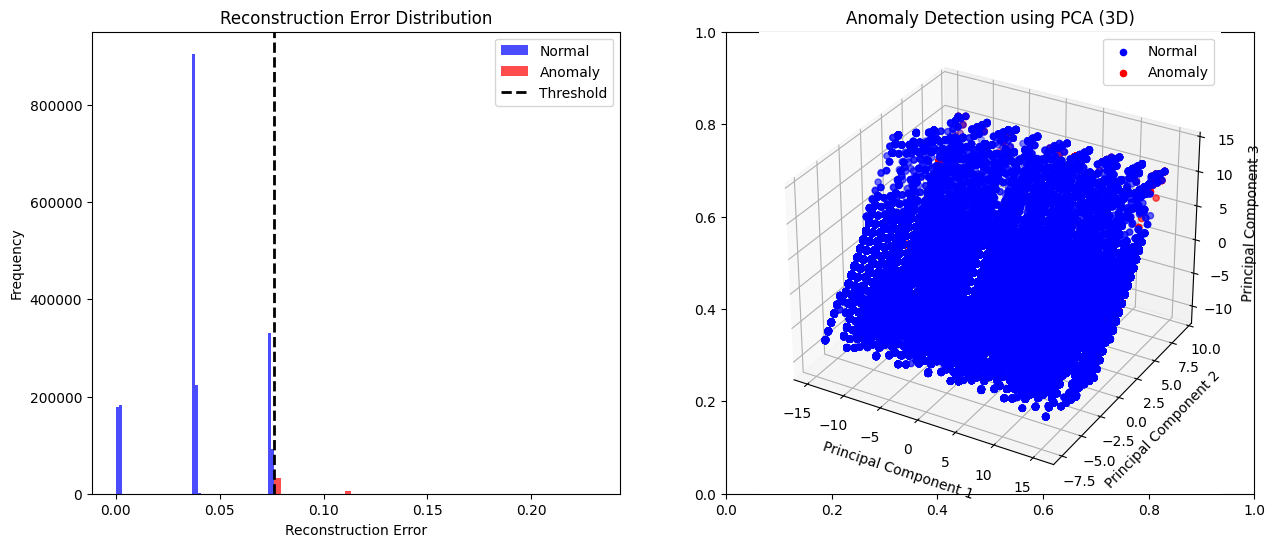

In [23]:
# Plotting 
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting anomalies histogram
axs[0].hist(mse[~anomaly_mask_ae], bins=50, color='blue', alpha=0.7, label='Normal')
axs[0].hist(mse[anomaly_mask_ae], bins=50, color='red', alpha=0.7, label='Anomaly')
axs[0].axvline(threshold, color='black', linestyle='dashed', linewidth=2, label='Threshold')
axs[0].set_title('Reconstruction Error Distribution')
axs[0].set_xlabel('Reconstruction Error')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Apply PCA with 3 components
pca = PCA(n_components=3)
X_pca_ae = pca.fit_transform(df)

# Plotting PCA visualization
axs[1] = fig.add_subplot(122, projection='3d')
axs[1].scatter(X_pca_ae[~anomaly_mask_ae, 0], X_pca_ae[~anomaly_mask_ae, 1], X_pca_ae[~anomaly_mask_ae, 2], c='blue', label='Normal')
axs[1].scatter(X_pca_ae[anomaly_mask_ae, 0], X_pca_ae[anomaly_mask_ae, 1], X_pca_ae[anomaly_mask_ae, 2], c='red', label='Anomaly')
axs[1].set_title('Anomaly Detection using PCA (3D)')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].set_zlabel('Principal Component 3')
axs[1].legend()

plt.show()


In [40]:
anomalies_dict = {index: mse[index] for index in anomalies_indices}
# print(anomalies_dict)


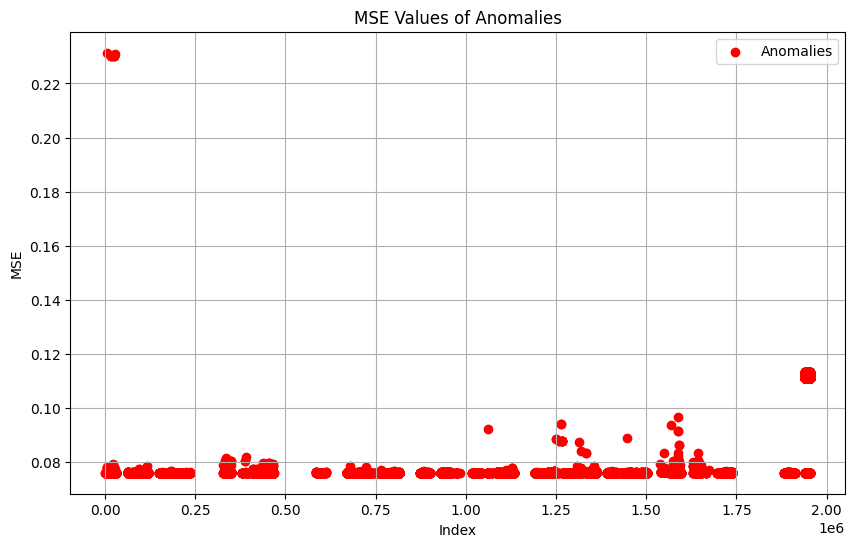

In [25]:
mse_values = list(anomalies_dict.values())

# Plot the MSE values against the indices
plt.figure(figsize=(10, 6))
plt.scatter(anomalies_indices, mse_values, color='red', label='Anomalies')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.title('MSE Values of Anomalies')
plt.legend()
plt.grid(True)
plt.show()


#### Part-2: False Positive reducer Model

**train reducer model**

In [26]:
# Prepare labeled dataset
X_train, X_test, y_train, y_test = train_test_split(df, anomaly_mask_ae, test_size=0.2, random_state=42)

Class False: 1532099 samples
Class True: 31140 samples


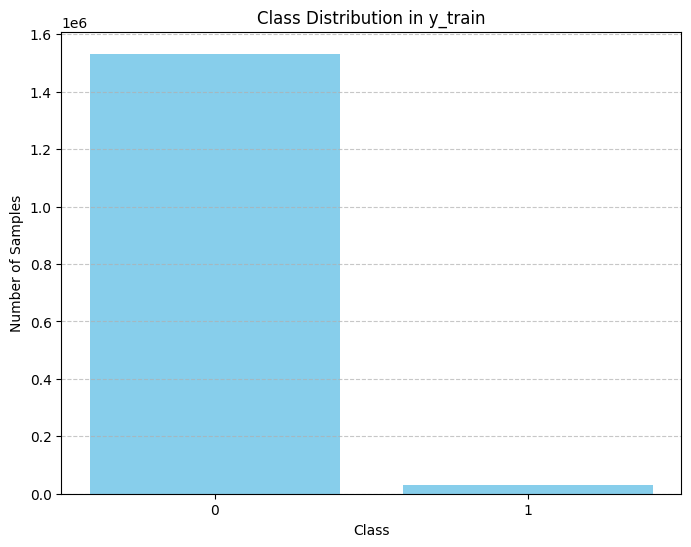

In [27]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
# Print class distribution
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in y_train')
plt.xticks(unique_classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [28]:
# resampling (SMOTE)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Class False: 1532099 samples
Class True: 1532099 samples


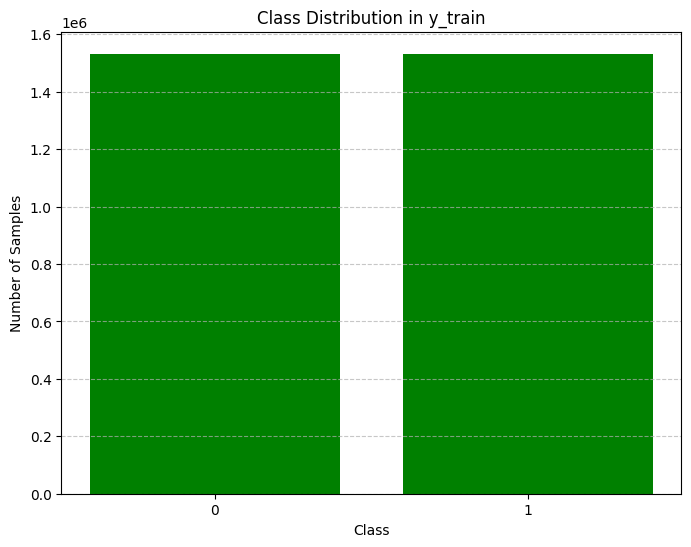

In [29]:
# check if balanced
unique_classes_smote, class_counts_smote = np.unique(y_train_smote, return_counts=True)
# Print class distribution
for cls, count in zip(unique_classes_smote, class_counts_smote):
    print(f"Class {cls}: {count} samples")
# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(unique_classes_smote, class_counts_smote, color='green')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in y_train')
plt.xticks(unique_classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [30]:
# Train 
fpr = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', random_state=42)
fpr.fit(X_train_smote, y_train_smote)
# Evaluate
accuracy = fpr.score(X_test, y_test)
print("False Positive Reducer Model Accuracy:", accuracy)

False Positive Reducer Model Accuracy: 0.9993756556894655


**refine anomalies**

In [31]:
# refine anomaly predictions
anomaly_predictions = anomaly_mask_ae.astype(int)
reduced_anomaly_predictions =fpr.predict(df)
num_reduced_anomalies = np.sum(reduced_anomaly_predictions)
print("Number of refined anomalies:", num_reduced_anomalies)

Number of refined anomalies: 40179


print lenth 1117


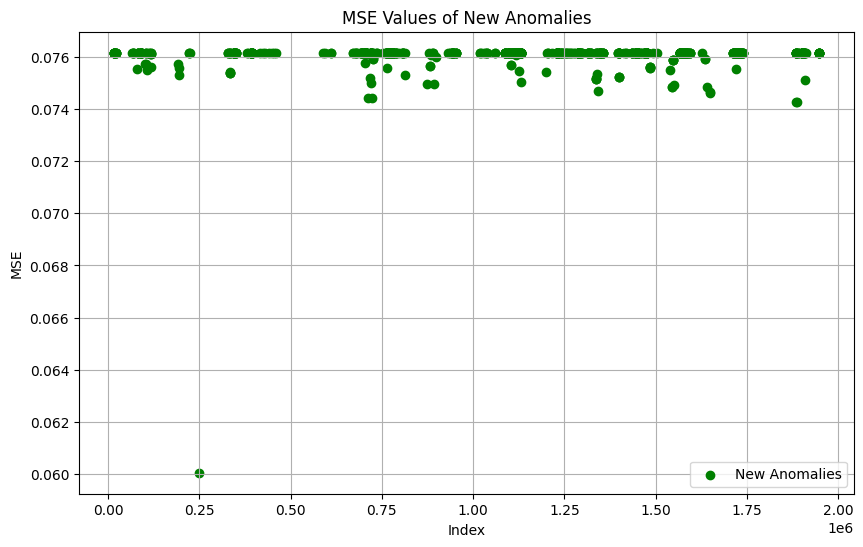

40179


In [32]:
# Filter indices of anomalies from refined anomaly predictions
refined_anomaly_indices = np.where(reduced_anomaly_predictions == 1)[0]

# Extract  MSE values 
refined_anomaly_mse = mse.iloc[refined_anomaly_indices]

# Find indices
new_anomaly_indices = np.setdiff1d(refined_anomaly_indices, anomalies_indices)
print("print lenth",len(new_anomaly_indices))

# Extract corresponding MSE values for new anomalies
new_anomaly_mse = mse.iloc[new_anomaly_indices]

# Plot MSE values of new anomalies
plt.figure(figsize=(10, 6))
plt.scatter(new_anomaly_indices, new_anomaly_mse, color='green', label='New Anomalies')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.title('MSE Values of New Anomalies')
plt.legend()
plt.grid(True)
plt.show()
print(len(refined_anomaly_indices))

In [33]:
anomalies_below_threshold = [index for index, mse_value in zip(new_anomaly_indices, new_anomaly_mse) if mse_value < threshold]
print(len(anomalies_below_threshold))

1117


**Plotting refined anomalies**

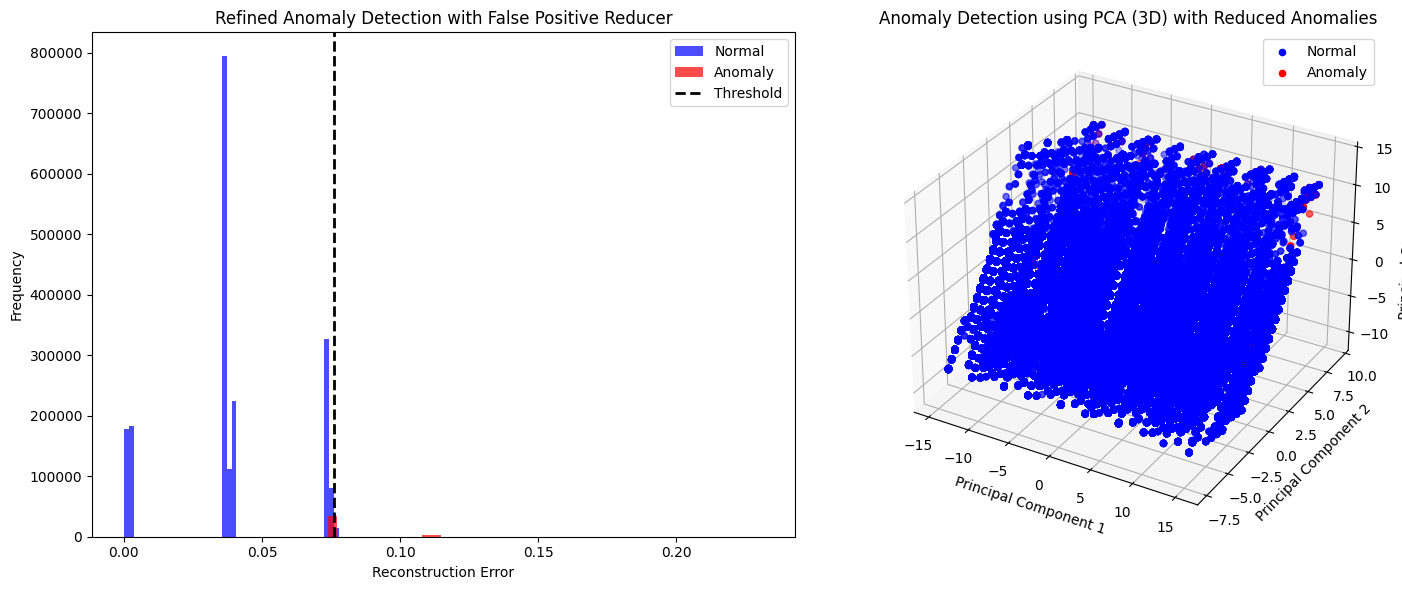

In [34]:
# Plotting refined anomalies histogram
plt.figure(figsize=(15, 6))

# Subplot for histogram
plt.subplot(1, 2, 1)
plt.hist(mse[~reduced_anomaly_predictions.astype(bool)], bins=50, color='blue', alpha=0.7, label='Normal')
plt.hist(mse[reduced_anomaly_predictions.astype(bool)], bins=50, color='red', alpha=0.7, label='Anomaly')
plt.axvline(threshold, color='black', linestyle='dashed', linewidth=2, label='Threshold')
plt.title('Refined Anomaly Detection with False Positive Reducer')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()

# Plotting PCA 
ax = plt.subplot(1, 2, 2, projection='3d')

# for normal points
ax.scatter(X_pca_ae[~reduced_anomaly_predictions.astype(bool), 0], X_pca_ae[~reduced_anomaly_predictions.astype(bool), 1], X_pca_ae[~reduced_anomaly_predictions.astype(bool), 2], c='blue', label='Normal')

# for anomaly points
ax.scatter(X_pca_ae[reduced_anomaly_predictions.astype(bool), 0], X_pca_ae[reduced_anomaly_predictions.astype(bool), 1], X_pca_ae[reduced_anomaly_predictions.astype(bool), 2], c='red', label='Anomaly')

ax.set_title('Anomaly Detection using PCA (3D) with Reduced Anomalies')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


**Prediction on real data**

In [35]:
# Func to predict
def predict_anomalies(data_point):
    # high recaller
    anomaly_flag = autoencoder.predict(data_point)
    mse = np.mean(np.square(anomaly_flag - data_point), axis=1)
    print(f"reconstruction error is : {mse}")
    # threshold 
    threshold = .01
    # Identify anomalies 
    anomaly_mask= (mse > threshold)
    print("anomaly?", anomaly_mask)
    # False Positive Reducer
    if anomaly_mask.any():
        final_anomaly_flag = fpr.predict(data_point)
    else:
        final_anomaly_flag = anomaly_mask
    
    return final_anomaly_flag


To avoid complexity I will create a df from the **preprocessed** df and make prediction with it . However it's common practice to take real world data points. In this case this data points need to preprocessed which I am avoiding here for simplicity.

In [36]:
# Randomly select 20 examples
random_indices = np.random.choice(df.index, size=20, replace=False)
df_new = df.loc[random_indices].reset_index(drop=True)
df_new.head(3)

,AMOUNT,VALUE_DATE_FLAG,TXN_INITIATOR_BRANCH_FREQ,ACC_HOST_BRANCH_FREQ,SOURCE_ACC_FREQ,TRDID_110003,TRDID_120001,TRDID_120006,TRDID_120089,TRDID_130002,...,INITIATOR_FREQ,TXN_MONTH,TXN_DAY,CREATE_HOUR,VERIFICATION_MONTH,TXN_DAY_OF_WEEK,VERIFICATION_DAY_OF_WEEK,CREATE_VERIFICATION_TIMEDIFF,TXN_END_OF_MONTH,TXN_WEEKEND
0,0.000140,0,0.018569,0.015701,0.000171,0.0,0.0,0.0,0.0,0.0,...,0.002628,1,23,13,1,6,6,0.0,0,1
1,0.000004,0,0.014908,0.012628,0.000018,0.0,0.0,0.0,1.0,0.0,...,0.002445,3,15,14,3,1,1,0.0,0,0
2,0.000004,0,0.023951,0.019660,0.001438,0.0,0.0,0.0,0.0,1.0,...,0.234117,3,13,13,3,6,6,0.0,0,1


In [37]:
# Predict
preds=[]
for i in  range(len(df_new)):
    new_example=df_new.iloc[i,:]
    new_example=new_example.values.reshape(-1,27)
    new_example=pd.DataFrame(new_example)
    anomaly_pred= predict_anomalies(new_example)
    if isinstance(anomaly_pred, list):
        preds.append(anomaly_pred[0])
    else:
        preds.append(anomaly_pred[0])



1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.074141
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.037073
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.076192
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - ETA: 0s

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.074133
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.000035
dtype: float64
anomaly? 0    False
dtype: bool
1/1 [==============================] - 0s 20ms/step
reconstruction error is : 0    0.0741
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - ETA: 0s

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.037072
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - 0s 21ms/step
reconstruction error is : 0    0.074118
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - 0s 18ms/step
reconstruction error is : 0    0.037104
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - ETA: 0s

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
reconstruction error is : 0    0.037055
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - 0s 20ms/step
reconstruction error is : 0    0.074137
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - 0s 20ms/step
reconstruction error is : 0    0.03706
dtype: float64
anomaly? 0    True
dtype: bool


c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
reconstruction error is : 0    0.037068
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - 0s 20ms/step
reconstruction error is : 0    0.037073
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - 0s 18ms/step
reconstruction error is : 0    0.07411
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - ETA: 0s

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.037082
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.000048
dtype: float64
anomaly? 0    False
dtype: bool
1/1 [==============================] - 0s 18ms/step
reconstruction error is : 0    0.037771
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - ETA: 0s

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
reconstruction error is : 0    0.039102
dtype: float64
anomaly? 0    True
dtype: bool
1/1 [==============================] - 0s 20ms/step
reconstruction error is : 0    0.037727
dtype: float64
anomaly? 0    True
dtype: bool


c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [38]:
# print predictions
print(preds)

[False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


**remarks**: all the cases are noraml. this is practical. Because most of the cases in real life are normal instead of an anomaly one. However, we can make df which could contain anomaly cases.

**NOTE**: Although setting threshold little, most of the predictions from the autoencoder is True. However, the false positive reducer model successfully predicted these points as noraml cases.